# Prerequisites

1. Prepare documents to be used in Amazon Bedrock Knowledge Base.
2. Add metadata to the input documents for advanced query features (covered in Lab2).
3. Create required AWS resources to run the Bedrock Knowledge Base service.
4. Create an Amazon OpenSearch Service collection as a vector store.

### 1. Environment

In [1]:
# Update python packages
!pip install -U boto3 opensearch-py 2>/dev/null

In [2]:
# Import utility functions
import advanced_rag_utils as aru
import boto3 

# Suppress warnings for cleaner output
aru.suppress_warnings()

#### Check which models have been enabled

In [3]:
# from list_bedrock_models import list_bedrock_models
# list_bedrock_models()

In [4]:
# Get AWS account information and set up authentication
region_name = "us-west-2"
aws_info = aru.get_aws_account_info(region_name)
account_number = aws_info["account_number"]
role_arn = aws_info["role_arn"]

# Print account details for verification
print(f"AWS Account: {account_number}")
print(f"Role ARN: {role_arn}")

AWS Account: 674655509879
Role ARN: arn:aws:sts::674655509879:assumed-role/rag-workshop-cfn-SageMakerExecutionRole-6W441Foaa8qv/SageMaker


In [5]:
# Get resource names for the workshop
resource_names = aru.get_resource_names(account_number, region_name)

# Extract resource names
s3_bucket_name = resource_names["s3_bucket_name"]
knowledge_base_name_aoss = resource_names["knowledge_base_name_aoss"]
knowledge_base_name_graphrag = resource_names["knowledge_base_name_graphrag"]
oss_vector_store_name = resource_names["oss_vector_store_name"]
oss_index_name = resource_names["oss_index_name"]


# Print resource names for verification
print(f"S3 Bucket Name: {s3_bucket_name}")
print(f"Knowledge Base (AOSS): {knowledge_base_name_aoss}")
print(f"Knowledge Base (GraphRAG): {knowledge_base_name_graphrag}")
print(f"OpenSearch Vector Store Name: {oss_vector_store_name}")
print(f"OpenSearch Index Name Prefix: {oss_index_name}")

S3 Bucket Name: 674655509879-us-west-2-advanced-rag-workshop
Knowledge Base (AOSS): advanced-rag-workshop-knowledgebase-aoss
Knowledge Base (GraphRAG): advanced-rag-workshop-knowledgebase-graphrag
OpenSearch Vector Store Name: advancedrag
OpenSearch Index Name Prefix: ws-index-


### 2. Create required AWS resources 

#### IAM Role

In [6]:
from bedrock_excution_iam_role import AdvancedRagIamRoles

# Initialize IAM role handler
bedrock_execution_iam_role = AdvancedRagIamRoles(account_number, region_name)

# Create or retrieve Bedrock execution role
bedrock_kb_execution_role_arn = aru.create_bedrock_execution_role(
    role_handler=bedrock_execution_iam_role,
    s3_bucket_name=s3_bucket_name
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
CloudWatch full access policy attached to advanced-rag-workshop-bedrock_execution_role-us-west-2
Bedrock logging policy attached to advanced-rag-workshop-bedrock_execution_role-us-west-2
Waiting for IAM changes to propagate...
Created Bedrock Knowledge Base Execution Role ARN: arn:aws:iam::674655509879:role/advanced-rag-workshop-bedrock_execution_role-us-west-2


In [7]:
aru.create_cloudwatch_log_group(log_group_name="AdvancedRAGWSLogGroup")
role_name = "advanced-rag-workshop-bedrock_execution_role-us-west-2"
br_role_arn = f"arn:aws:iam::{account_number}:role/{role_name}"
print(br_role_arn) 

client = boto3.client('bedrock')
update_log_group_response = client.put_model_invocation_logging_configuration(
    loggingConfig={
        'cloudWatchConfig': {
            'logGroupName': 'AdvancedRAGWSLogGroup',
            'roleArn': br_role_arn
        }
    }
)
update_log_group_response

arn:aws:iam::674655509879:role/advanced-rag-workshop-bedrock_execution_role-us-west-2


{'ResponseMetadata': {'RequestId': '71d27891-9340-4255-af28-78234d8f927b',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Fri, 02 May 2025 06:13:57 GMT',
   'content-type': 'application/json',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': '71d27891-9340-4255-af28-78234d8f927b'},
  'RetryAttempts': 0}}

#### S3 bucket

In [8]:
# Create the S3 bucket if it doesn't exist
aru.create_s3_bucket(s3_bucket_name, region_name)

Bucket '674655509879-us-west-2-advanced-rag-workshop' already exists.


True

### 3. Preparing Data Sources with .metadata.json

### Role of Metadata While Indexing Data in Vector Databases  

Metadata provides additional context and information about the documents, which can be used to filter, sort, and improve search accuracy. This not only helps reduce the search latency but also helps increase accuracy of responses.  

The following are some key uses of metadata when loading documents into a vector data store:  

- **Document Identification** – Metadata can include unique identifiers for each document, such as document IDs, URLs, or file names. These identifiers can be used to uniquely reference and retrieve specific documents from the vector data store.  
- **Content Categorization** – Metadata can provide information about the content or category of a document, such as the subject matter, domain, or topic. This information can be used to organize and filter documents based on specific categories or domains.  
- **Document Attributes** – Metadata can store additional attributes related to the document, such as the author, publication date, language, or any other relevant information. These attributes can be used for filtering, sorting, or faceted search within the vector data store.  
- **Access Control** – Metadata can include information about access permissions or security levels associated with a document. This information can be used to control access to sensitive or restricted documents within the vector data store.  
- **Relevance Scoring** – Metadata can be used to enhance the relevance scoring of search results. For example, if a user searches for documents within a specific date range or authored by a particular individual, the metadata can be used to prioritize and rank the most relevant documents.  
- **Data Enrichment** – Metadata can be used to enrich the vector representations of documents by incorporating additional contextual information. This can potentially improve the accuracy and quality of search results.  
- **Data Lineage and Auditing** – Metadata can provide information about the provenance and lineage of documents, such as the source system, data ingestion pipeline, or any transformations applied to the data. This information can be valuable for data governance, auditing, and compliance purposes.  


#### 3.1 Unstructured (PDF) document

#### Amazon Science papers

In [9]:
# Download Amazon Science papers, prepare metadata, and upload to S3
aru.download_and_prepare_science_papers(s3_bucket_name, region_name)

#### Amazon 10-K filings

In [10]:
# Download Amazon 10-K reports, prepare metadata, and upload to S3
aru.download_and_prepare_10k_reports(s3_bucket_name, region_name)

#### 3.2 Metadata customization for CSV files
The data is downloaded from [here](https://github.com/ali-ce/datasets) and it is licensed under [Creative Commons Attribution-ShareAlike 4.0 International license](https://github.com/ali-ce/datasets/blob/master/README.md#:~:text=Creative%20Commons%20Attribution%2DShareAlike%204.0%20International%20License.).

In [11]:
# Download CSV data, prepare metadata, and upload to S3
aru.download_and_prepare_csv_data(s3_bucket_name, region_name)

CSV file downloaded successfully: ./videogame/video_games.csv
JSON metadata file './videogame/video_games.metadata.json' has been generated.


### 4. Create a Vector Store using Amazon Open Search Serveless

#### 4.1 Amazon OpenSearch Vector Collection  
This will be used in Amazon Bedrock Knowledge Bases.  

### **Code Steps:**  
1. **Create security, network, and data access policies** within Amazon OpenSearch Serverless.  
   - These will be assigned to the OpenSearch Vector Collection.  
2. **Create an OpenSearch Serverless Vector Collection.**  
3. **Retrieve the OpenSearch Serverless collection URL** for the Vector Collection created above.  
4. **Wait for the Vector Collection** to reach the "Ready" state.  
5. **Create an OpenSearch Serverless access policy** and attach it to the Bedrock execution role.


> **Note**: This process will take approximately 4-5 minutes to complete. The system is creating security policies, network configurations, and a vector collection for storing embeddings.

In [12]:
import boto3

# Initialize the OpenSearch Serverless client
aoss = boto3.client("opensearchserverless", region_name=region_name)

print("Creating OpenSearch Serverless vector collection. This process will take approximately 4-5 minutes...")

# Create security, network, and data access policies for OpenSearch
policies = aru.create_opensearch_policies(
    iam_role_handler=bedrock_execution_iam_role,
    vector_store_name=oss_vector_store_name,
    aoss_client=aoss,
    execution_role_arn=bedrock_kb_execution_role_arn
)

# Create OpenSearch Serverless Vector Collection
collection_id, host = aru.create_opensearch_collection(
    aoss_client=aoss,
    collection_name=oss_vector_store_name,
    region_name=region_name
)

# Wait for collection to become active
aru.wait_for_collection_active(aoss, oss_vector_store_name)

# Create OpenSearch access policy and attach to Bedrock execution role
# aru.create_opensearch_access_policy(
#     iam_role_handler=bedrock_execution_iam_role,
#     collection_id=collection_id,
#     execution_role=bedrock_kb_execution_role_arn
# )

aru.create_oss_policy_attach_bedrock_execution_role(
        bedrock_kb_execution_role=role_name,
        collection_id=collection_id,
        account_number=account_number,
        region_name=region_name
        
   )


Creating OpenSearch Serverless vector collection. This process will take approximately 4-5 minutes...
Encryption policy already exists or error: An error occurred (ConflictException) when calling the CreateSecurityPolicy operation: Policy with name advanced-rag-enc-policy2 and type encryption already exists
Network policy already exists or error: An error occurred (ConflictException) when calling the CreateSecurityPolicy operation: Policy with name advanced-rag-network-policy2 and type network already exists
Access policy already exists or error: An error occurred (ConflictException) when calling the CreateAccessPolicy operation: Policy with name advanced-rag-access-policy2 and type data already exists
Error: cannot access local variable 'encryption_policy' where it is not associated with a value
Policies already exist or were not created properly.
Collection 'advancedrag' already exists.
Collection Host URL: itgjkhz5b0epjlrptxql.us-west-2.aoss.amazonaws.com
{'collectionDetails': [{'id

#### 4.2 Create an index for the collection

This index will be managed via Bedrock Knowledge Bases.

**Code Steps:**

1. **Create Index Body JSON**: Define the metadata or index structure that will be used for indexing in the OpenSearch Vector Collection.
   
2. **Create OpenSearch Object**: Instantiate an object of the `OpenSearch` class from the `opensearchpy` Python module. This object will be used to connect to the OpenSearch Vector Collection.

3. **Create Index**: Using the OpenSearch object and the index body JSON, create the index in the OpenSearch Vector Collection.

   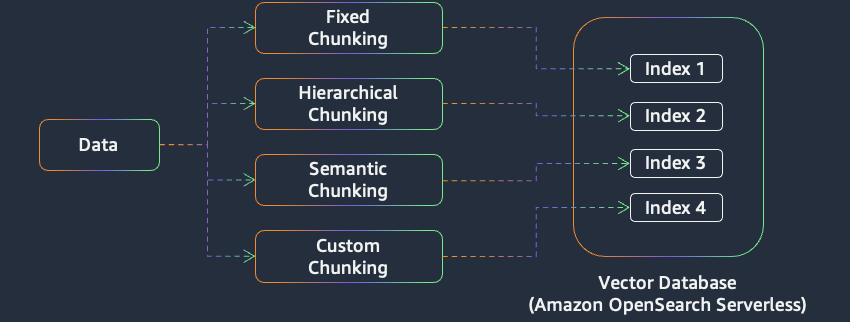


In [14]:
# Create indexes for different chunking strategies
aru.create_opensearch_index(
    collection_host=host,
    index_name_prefix=oss_index_name,
    region_name=region_name
)

[05/02/25 06:14:37] INFO     PUT                                                                        ]8;id=873049;file:///opt/conda/lib/python3.12/site-packages/opensearchpy/connection/base.py\base.py]8;;\:]8;id=932338;file:///opt/conda/lib/python3.12/site-packages/opensearchpy/connection/base.py#258\258]8;;\
                             https://itgjkhz5b0epjlrptxql.us-west-2.aoss.amazonaws.com:443/ws-index-fix            
                             ed                                                                                    

Creating Index: ws-index-fixed...


                    INFO     PUT                                                                        ]8;id=29833;file:///opt/conda/lib/python3.12/site-packages/opensearchpy/connection/base.py\base.py]8;;\:]8;id=47727;file:///opt/conda/lib/python3.12/site-packages/opensearchpy/connection/base.py#258\258]8;;\
                             https://itgjkhz5b0epjlrptxql.us-west-2.aoss.amazonaws.com:443/ws-index-hie            
                             rarchical                                                                             

Creating Index: ws-index-hierarchical...


                    INFO     PUT                                                                        ]8;id=566372;file:///opt/conda/lib/python3.12/site-packages/opensearchpy/connection/base.py\base.py]8;;\:]8;id=767663;file:///opt/conda/lib/python3.12/site-packages/opensearchpy/connection/base.py#258\258]8;;\
                             https://itgjkhz5b0epjlrptxql.us-west-2.aoss.amazonaws.com:443/ws-index-sem            
                             antic                                                                                 

Creating Index: ws-index-semantic...


                    INFO     PUT                                                                        ]8;id=576986;file:///opt/conda/lib/python3.12/site-packages/opensearchpy/connection/base.py\base.py]8;;\:]8;id=423799;file:///opt/conda/lib/python3.12/site-packages/opensearchpy/connection/base.py#258\258]8;;\
                             https://itgjkhz5b0epjlrptxql.us-west-2.aoss.amazonaws.com:443/ws-index-cus            
                             tom                                                                                   

Creating Index: ws-index-custom...
Index Creation Process Completed.


### Export variables to a file for the next lab

> **Note**: We're saving all the important configuration variables to a JSON file so they can be easily accessed in subsequent notebooks. This ensures consistency and prevents the need to recreate these resources for each notebook in the workshop.

In [15]:
# Create a collection ARN using the standard format
collection_arn = f"arn:aws:aoss:{region_name}:{account_number}:collection/{collection_id}"

# Prepare variables to save
variables_to_save = {
    "accountNumber": account_number,
    "regionName": region_name,
    "collectionArn": collection_arn,
    "collectionId": collection_id,
    "vectorIndexName": oss_index_name,
    "bedrockExecutionRoleArn": bedrock_kb_execution_role_arn,
    "s3Bucket": s3_bucket_name
}

# Save variables to JSON file
aru.save_variables_to_json(variables_to_save, "../variables.json")

Variables saved to ../variables.json
